In [35]:
# Import manipulating files libraries
import os, glob

# Import graph/image plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating libraries
import numpy as np
import pandas as pd

# Import deep learning model libraries
import tensorflow as tf
import keras
from keras.callbacks import TensorBoard
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import date/time library to save models with date/time
from datetime import datetime

In [36]:
# Get data path
data_path = 'final data/*.nii.gz'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

# Get the labels for our data from our csv file
Labels = pd.read_csv('labels.csv')
# Define our target from the column "Labels" as our y in our model
target = Labels['group']

In [37]:
# Loop through files and load all data files
data_all, images = [], []
for data_file in sorted(files):
    data = nib.load(data_file).get_fdata()
    first_vol = data[:,:,:,0]
    first = first_vol / 255
    data_all.append(first)
    
# Convert our list into a numpy array
images = np.asarray(data_all)

print(len(data_all))
print (np.shape(images))

120
(120, 64, 64, 34)


In [38]:
print(images[3])

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.03921569 0.04705882 0.05098039 ... 0.03529412 0.04313725 0.03137255]
  [0.03921569 0.03529412 0.05098039 ... 0.04313725 0.03529412 0.04313725]
  [0.04705882 0.05098039 0.04313725 ... 0.05098039 0.03529412 0.04313725]
  ...
  [0.0745098  0.09411765 0.10196078 ... 0.05882353 0.05098039 0.05882353]
  [0.08235294 0.06666667 0.09411765 ... 0.05098039 0.05098039 0.05490196]
  [0.07058824 0.0745098  0.09019608 ... 0.05490196 0.05490196 0.05882353]]

 [[0.03921569 0.05098039 0.06666667 ... 0.05098039 0.03921569 0.03921569]
  [0.04705882 0.054901

In [39]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:60]
con = indexes[60:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.7 * size)
split_2 = int(0.85 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]
X_train.shape

(84, 64, 64, 34)

In [40]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]

In [41]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('int32')
y_test = np.asarray(y_test).astype('int32')
y_val = np.asarray(y_val).astype('int32')

In [42]:
y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)
y_val = tf.one_hot(y_val, 2)
print(y_val) 

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(18, 2), dtype=float32)


In [43]:
# Here we begin to create our sequential model

# Get shape of input data
data_shape = tuple(X_train.shape[1:])
# We check the shape of our data (Nifti files)
print(data_shape)

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 16

(64, 64, 34)


In [44]:
y_train.shape

TensorShape([84, 2])

In [50]:
# Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers
K.clear_session()
# Set learning phase from our model to training
K.set_learning_phase(1)

# Create our Modified LeNet-5 model
model = Sequential()

# Add blocks of convolutional layers followed by batch normalization and pooling
model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Reshape the tensor to have the shape that is equal to the number of elements contained 
# in tensor non including the batch dimension
model.add(Flatten())

# Add the fully connected layer followed by a dropout of 50%
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# We finally add the softmax classifier to our model
model.add(Dense(n_classes, activation='sigmoid', name='preds'))

# Define the learning rate to our optimizer and which optimizer we will use
from keras import optimizers
learning_rate = 1e-5
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Here we configure the loss and metrics of our model
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs = 200,
              batch_size= 12,
              verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        4912      
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 32)       128       
 hNormalization)                                                 
                                                        

C:\Users\achin\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Epoch 1/200
7/7 [==============================] - 2s 120ms/step - loss: 1.3362 - accuracy: 0.4524 - val_loss: 0.7341 - val_accuracy: 0.5000
Epoch 2/200
7/7 [==============================] - 0s 63ms/step - loss: 0.6225 - accuracy: 0.7381 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 3/200
7/7 [==============================] - 0s 65ms/step - loss: 0.5940 - accuracy: 0.6429 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 4/200
7/7 [==============================] - 0s 64ms/step - loss: 0.4939 - accuracy: 0.7976 - val_loss: 0.6750 - val_accuracy: 0.5000
Epoch 5/200
7/7 [==============================] - 0s 54ms/step - loss: 0.4286 - accuracy: 0.8452 - val_loss: 0.6585 - val_accuracy: 0.8333
Epoch 6/200
7/7 [==============================] - 0s 58ms/step - loss: 0.3864 - accuracy: 0.8452 - val_loss: 0.6607 - val_accuracy: 0.7778
Epoch 7/200
7/7 [==============================] - 0s 63ms/step - loss: 0.2651 - accuracy: 0.9167 - val_loss: 0.6724 - val_accuracy: 0.5000
Epoch 8/200
7/7 [==

7/7 [==============================] - 0s 47ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.3482 - val_accuracy: 0.7778
Epoch 60/200
7/7 [==============================] - 0s 49ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.3250 - val_accuracy: 0.8333
Epoch 61/200
7/7 [==============================] - 0s 52ms/step - loss: 0.0176 - accuracy: 0.9881 - val_loss: 0.2985 - val_accuracy: 0.8889
Epoch 62/200
7/7 [==============================] - 0s 53ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3158 - val_accuracy: 0.8889
Epoch 63/200
7/7 [==============================] - 0s 52ms/step - loss: 0.0096 - accuracy: 0.9881 - val_loss: 0.4547 - val_accuracy: 0.8333
Epoch 64/200
7/7 [==============================] - 0s 50ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.4447 - val_accuracy: 0.8333
Epoch 65/200
7/7 [==============================] - 0s 52ms/step - loss: 0.0427 - accuracy: 0.9643 - val_loss: 1.7809 - val_accuracy: 0.6111
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 69ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.0684 - val_accuracy: 0.8333
Epoch 118/200
7/7 [==============================] - 0s 59ms/step - loss: 0.0166 - accuracy: 0.9881 - val_loss: 1.0619 - val_accuracy: 0.8333
Epoch 119/200
7/7 [==============================] - 0s 70ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 1.0707 - val_accuracy: 0.8333
Epoch 120/200
7/7 [==============================] - 0s 71ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.0736 - val_accuracy: 0.8333
Epoch 121/200
7/7 [==============================] - 0s 71ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.0989 - val_accuracy: 0.8333
Epoch 122/200
7/7 [==============================] - 0s 70ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.1329 - val_accuracy: 0.8333
Epoch 123/200
7/7 [==============================] - 0s 67ms/step - loss: 0.0337 - accuracy: 0.9762 - val_loss: 1.1504 - val_accuracy: 0.8333
Epoch 124/200
7/7 [=

7/7 [==============================] - 0s 70ms/step - loss: 4.2690e-05 - accuracy: 1.0000 - val_loss: 2.4208 - val_accuracy: 0.7778
Epoch 175/200
7/7 [==============================] - 0s 70ms/step - loss: 3.9286e-04 - accuracy: 1.0000 - val_loss: 2.4241 - val_accuracy: 0.7778
Epoch 176/200
7/7 [==============================] - 1s 73ms/step - loss: 9.4200e-04 - accuracy: 1.0000 - val_loss: 2.4548 - val_accuracy: 0.7778
Epoch 177/200
7/7 [==============================] - 0s 70ms/step - loss: 4.3979e-05 - accuracy: 1.0000 - val_loss: 2.4794 - val_accuracy: 0.7778
Epoch 178/200
7/7 [==============================] - 1s 74ms/step - loss: 1.8158e-04 - accuracy: 1.0000 - val_loss: 2.4778 - val_accuracy: 0.7778
Epoch 179/200
7/7 [==============================] - 0s 68ms/step - loss: 5.2081e-05 - accuracy: 1.0000 - val_loss: 2.4636 - val_accuracy: 0.7778
Epoch 180/200
7/7 [==============================] - 0s 67ms/step - loss: 0.0252 - accuracy: 0.9881 - val_loss: 2.1991 - val_accuracy: 0.8

In [51]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 33ms/step - loss: 0.6318 - accuracy: 0.9444


[0.6318085193634033, 0.9444444179534912]

In [52]:
# Analyze prediction values



predicted = model.predict(X_test)
predicted[:,:]

1/1 [==============================] - 0s 123ms/step


array([[1.00000000e+00, 7.12741033e-10],
       [1.00000000e+00, 7.38549291e-11],
       [1.00000000e+00, 2.88932096e-08],
       [1.00000000e+00, 6.62218707e-13],
       [1.00000000e+00, 1.00119095e-07],
       [1.00000000e+00, 3.66651015e-11],
       [9.99999702e-01, 1.82172664e-06],
       [1.00000000e+00, 1.25181948e-11],
       [1.00000000e+00, 2.30819612e-14],
       [3.21415996e-08, 9.99999881e-01],
       [3.45746885e-05, 9.99958038e-01],
       [1.19454392e-12, 1.00000000e+00],
       [1.39374231e-06, 9.99995291e-01],
       [1.63204297e-10, 1.00000000e+00],
       [2.60283002e-07, 9.99999106e-01],
       [2.59300936e-09, 1.00000000e+00],
       [9.99994516e-01, 4.34115100e-05],
       [3.36368412e-01, 8.39219451e-01]], dtype=float32)

In [53]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

1/1 [==============================] - 0s 43ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.89      0.94         9

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18



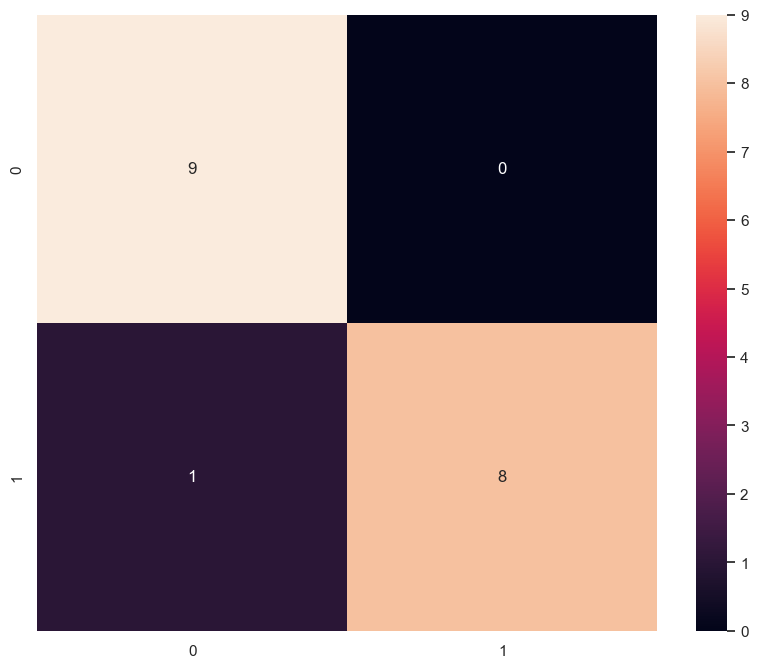

In [54]:
# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");